Nesse projeto uso LSTM para descobrir qual é o preço de fechamento do bitcoin. Uso 5 features relativas ao candle de negociação diária e prevejo o preço de fechamento do dia seguinte



In [42]:
!pip install keras-tuner
!pip install tensorflow
!pip install numpy
!pip install pandas

In [43]:
#Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
# from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [44]:
TIME_STEP = 30           #número de dias usados para prever o futuro
JUMP_STEP = 1
NUM_FEATURES = 5
NUM_PREDICT_FUTURE = 1      #número do dia a serem preditos no futuro (prever o próximo dia? Prever o 7º dia?)
PATH = './drive/MyDrive/TCC/single_lstm_regression1/'
THRESHOLD = 5


## Definição das Seeds


In [45]:
import tensorflow as tf
import numpy as np

# Defina a semente do TensorFlow
tf.random.set_seed(0)

# Defina a semente do NumPy
np.random.seed(0)


## Importar a Base de Dados

In [46]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 10, 30, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [47]:
# def selecionaValores(df, jump_step):
#   return df[0::jump_step]

# df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [48]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

data.dropna(inplace=True)
data.reset_index(inplace = True)


In [49]:
# Definir os dataframes dos objetivos a serem alcançados pelo modelo. O Y. Baseados no TimeStep e numero do dia a ser predito

ignoreDays = TIME_STEP + NUM_PREDICT_FUTURE - 1
index = np.array(df.index)[ignoreDays:]

# Dataframe com o valor de fechamento
target_df_Close = pd.DataFrame(df['Close'], index, ['Close']).rename(columns={'Close':'YClose'})

# Dataframe com a variação nominal entre os dias
array_change = np.array(target_df_Close.YClose) - np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Change = pd.DataFrame(array_change, index, columns=['Close']).rename(columns={'Close':'YChange'})

# Dataframe com a variação percentual entre os dias
array_variation = np.array(target_df_Change.YChange) / np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Variation = pd.DataFrame(array_variation*100, index, ['Close']).rename(columns={'Close':'YVariation'})


# Dataframe com a Classe baseado na variação percentual entre os dias
def defineClass(variation):
  if variation > THRESHOLD:
    return 2
  elif variation < -THRESHOLD:
    return 0
  else:
    return 1
# Apply the defineClass function to each data point in the array_variation
classifications = [defineClass(variation*100) for variation in array_variation]
target_df_Class = pd.DataFrame(classifications, index, ['Close']).rename(columns={'Close':'YClass'})

In [50]:
df.Close.size, target_df_Close.size, target_df_Change.size, target_df_Variation.size

(3331, 3301, 3301, 3301)

In [51]:
#plt.plot(df.index, df['Close'])

## Divisão em Treino, Validação e Teste

In [52]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(target_df_Close)
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

x_train_data = df[: train_size + TIME_STEP - 1]
x_val_data = df[ train_size : (train_size + validation_size + TIME_STEP - 1)]
x_test_data = df[train_size + validation_size : -NUM_PREDICT_FUTURE]

y_train_data = target_df_Close[: train_size]
y_val_data = target_df_Close[train_size : (train_size + validation_size)]
y_test_data = target_df_Close[(train_size + validation_size) :]

#Serão usados nas etapas finais do projeto
y_train_class = target_df_Class[: train_size]
y_val_class = target_df_Class[train_size : (train_size + validation_size)]
y_test_class = target_df_Class[(train_size + validation_size) :]

y_train_variation = target_df_Variation[: train_size]
y_val_variation = target_df_Variation[train_size : (train_size + validation_size)]
y_test_variation = target_df_Variation[(train_size + validation_size) :]




In [53]:
size, train_size, validation_size, test_size

(3301, 2310, 330, 661)

In [54]:
x_train_data.shape, x_val_data.shape, x_test_data.shape, y_train_data.shape, y_val_data.shape, y_test_data.shape

((2339, 5), (359, 5), (690, 5), (2310, 1), (330, 1), (661, 1))

In [55]:
#Transforma os dados para suavizar as variações em escala absoluta
# Transforma input data
scaler_train_input = MinMaxScaler(feature_range=(0, 1))
scaled_train_input = scaler_train_input.fit_transform(x_train_data)

scaled_val_input = scaler_train_input.transform(x_val_data)
scaled_test_input = scaler_train_input.transform(x_test_data)

# Transforma output data para o log do resultado
# scaled_train_output = np.array(y_train_data)
# scaled_val_output = np.array(y_val_data)
# scaled_test_output = np.array(y_test_data)
scaled_train_output = np.log10(np.array(y_train_data))
scaled_val_output = np.log10(np.array(y_val_data))
scaled_test_output = np.log10(np.array(y_test_data))

In [56]:
def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(y)):
    row = np.array([e for e in x[i : i + time_step]])
    input.append(row)
    output.append(y[i])
  return np.array(input), np.array(output)

x_train, y_train = createDataset(scaled_train_input, scaled_train_output, TIME_STEP)
x_val, y_val = createDataset(scaled_val_input, scaled_val_output, TIME_STEP)
x_test, y_test = createDataset(scaled_test_input, scaled_test_output, TIME_STEP)

print(df.shape)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3331, 5)
(2310, 30, 5) (2310, 1)
(330, 30, 5) (330, 1)
(661, 30, 5) (661, 1)


In [57]:
train_size, validation_size, test_size

(2310, 330, 661)

## Construção do Modelo LSTM

### Random Search com LSTM



In [58]:
import keras_tuner as kt
import keras.backend as K

def build_singleLayer_lstm_model(hp):
  #Variables to change with RandomSearch
  units = hp.Int('num_lstm_units', min_value=16, max_value=128, step=16)
  dropout = hp.Float('dropout_rate', min_value=0, max_value=0.4)
  learningRate = hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log')
  activation = hp.Choice('activation', ['tanh', 'relu'])

  model = keras.Sequential()
  model.add(LSTM(
      units = units,
      return_sequences=False,
      input_shape = (x_train.shape[1], x_train.shape[2]),
      activation=activation
      ))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=learningRate)
  model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])
  return model

earlystopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_singleLayer_lstm_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory=PATH,
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=25, validation_data=(x_val, y_val), callbacks=[earlystopping], batch_size=32, verbose=2)
tuner.results_summary()

#Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0];
best_model.save(PATH + 'best_model_tunner.hdf5');
best_model.build(x_train.shape);
best_model.summary();
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0];


Trial 100 Complete [00h 01m 34s]
val_loss: 0.00666718278080225

Best val_loss So Far: 0.00047855949378572404
Total elapsed time: 01h 45m 06s
Results summary
Results in ./drive/MyDrive/TCC/single_lstm_regression1/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 058 summary
Hyperparameters:
num_lstm_units: 80
dropout_rate: 0.08970502410956756
learning_rate: 0.05451882179711826
activation: tanh
Score: 0.00047855949378572404

Trial 009 summary
Hyperparameters:
num_lstm_units: 64
dropout_rate: 0.011509237867470157
learning_rate: 0.028081091473377076
activation: tanh
Score: 0.0004978643264621496

Trial 012 summary
Hyperparameters:
num_lstm_units: 32
dropout_rate: 0.2252204642644421
learning_rate: 0.03502955998570227
activation: tanh
Score: 0.0006467627827078104

Trial 029 summary
Hyperparameters:
num_lstm_units: 96
dropout_rate: 0.025453335860688278
learning_rate: 0.0454541670201498
activation: tanh
Score: 0.0006511890096589923

Trial 013 summary
Hyperpar

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Mostra Treina o melhor modelo com EarlyStop

In [41]:
best_model = load_model(PATH + 'best_model_tunner.hdf5')
best_model.build(x_train.shape);
best_model.summary();

earlystopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

#Define um checkpoint para a melhor época
checkpoint_path = PATH + 'best_model_earlyStop.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint, earlystopping]
#Train the best model
history = best_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=2,
                              callbacks=callbacks)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 96)                39168     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 39265 (153.38 KB)
Trainable params: 39265 (153.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 - 6s - loss: 0.0850 - mean_squared_error: 0.0850 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - 6s/epoch - 95ms/step
Epoch 2/500
67/67 - 2s - loss: 0.0521 - mean_squared_error: 0.0521 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - 2s/epoch - 22ms/step
Epoch 3/500
67/67 - 1s - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - 1s/epoch - 22ms/step
Epoch 4/500
67/67 - 2s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - 2s/epoch - 28ms/step
Epoch 5/500
67/67 - 2s - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - 2s/epoch - 23ms/step
Epoch 6/500
67/67 - 1s - loss: 0.0393 - mean_squared_error: 0.0393 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - 1s/epoch - 22ms/step
Epoch 7/500
67/67 - 2s - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - 2s/epoch - 23ms/step
Epoch 8/500
67/67 

## Resultados


Gráfico de Perda por Época


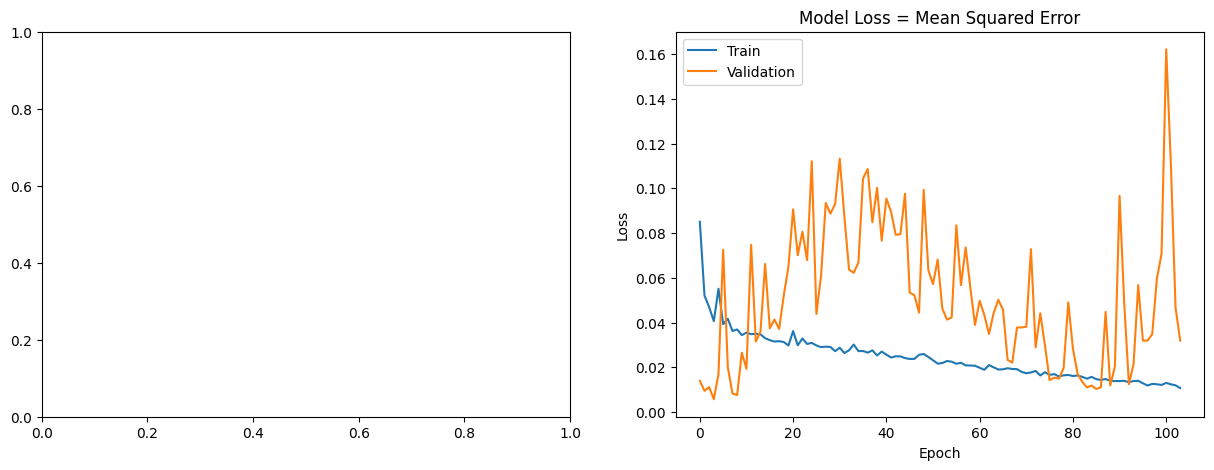

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(history.history['r_square'])
# ax1.plot(history.history['val_r_square'])
# ax1.set_title('Model r_square')
# ax1.set_ylabel('r_square')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss = Mean Squared Error')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Métricas de Desempenho


In [60]:
y_train_predict_log = best_model.predict(x_train)

y_val_predict_log = best_model.predict(x_val)

y_test_predict_log = best_model.predict(x_test)

def printResults(expected, result):
  mse = mean_squared_error(expected, result)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(expected, result)
  r2 = r2_score(expected, result)
  mape = np.mean(np.abs((expected - result) / expected)) * 100
  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAPE: {mape}%")
  print(f"R²: {r2}")


print('------------- Train -------------')
printResults(y_train, y_train_predict_log)
print('---------- Validation -----------')
printResults(y_val, y_val_predict_log)
print('-------------- Test -------------')
printResults(y_test, y_test_predict_log)




21/21 [==============================] - 0s 8ms/step
------------- Train -------------
MAE: 0.03524350793092323
MSE: 0.0027599387834530446
RMSE: 0.05253511952449565
MAPE: 1.215180425387723%
R²: 0.9935169387773775
---------- Validation -----------
MAE: 0.0162978827291418
MSE: 0.000478560562521894
RMSE: 0.021876027119243885
MAPE: 0.3490527674862148%
R²: 0.9361119808907272
-------------- Test -------------
MAE: 0.012084160699523788
MSE: 0.0002449940641202167
RMSE: 0.015652286226625702
MAPE: 0.27308080889013864%
R²: 0.9827933670841486


## Transformar Regressão e Classes


In [61]:
# y_test_predict = valor predito
# y_test = preço real
# y_test_class = a classe da variação percentual real
# y_test_variation = a variação percentual real
# Para prever o percentual predito, é necessário encontrar o valor real anterior
# Para isso, deve-se usar o valor real e a variação real. Variação = (V_final - V_inicial)/V_inicial
y_test_predict = 10 ** y_test_predict_log
y_test_real = 10 ** y_test
y_test_variation = np.array(y_test_variation)
y_test_class = np.array(y_test_class)

def defineClass(variation):
  if variation > THRESHOLD:
    return 2
  elif variation < -THRESHOLD:
    return 0
  else:
    return 1
def find_initial_price(preco_final, variacao_percentual):
  return preco_final / (1 + (variacao_percentual / 100))

y_test_initial = [find_initial_price(y_test_real[i], y_test_variation[i]) for i in range(len(y_test_real))]

y_test_variation_predict = ((y_test_predict - y_test_initial) / y_test_initial) * 100

y_test_class_predict = [defineClass(variation) for variation in y_test_variation_predict]




Mostrar as métricas de Classificação


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Transforme as classes reais e previstas em rótulos binários
lb = LabelBinarizer()
y_test_class_bin = lb.fit_transform(y_test_class)
y_test_class_predict_bin = lb.transform(y_test_class_predict)

accuracy = accuracy_score(y_test_class, y_test_class_predict)
# Precisão, Recall e F1-Score (para cada classe)
precision = precision_score(y_test_class, y_test_class_predict, average=None)
recall = recall_score(y_test_class, y_test_class_predict, average=None)
f1 = f1_score(y_test_class, y_test_class_predict, average=None)
auc = roc_auc_score(y_test_class_bin, y_test_class_predict_bin, average=None)

average_precision = precision_score(y_test_class, y_test_class_predict, average='micro')
average_recall = recall_score(y_test_class, y_test_class_predict, average='micro')
average_f1 = f1_score(y_test_class, y_test_class_predict, average='micro')
average_auc = roc_auc_score(y_test_class_bin, y_test_class_predict_bin, average='micro')

# Calcule o AUC médio para todas as classes
# None (padrão): Nesse caso, o AUC é calculado separadamente para cada classe e retornado como uma matriz. Não é um AUC médio.
# micro: Calcula o AUC médio considerando todas as instâncias individualmente. Ele faz isso tratando todas as previsões como uma única matriz de valores verdadeiros e previstos, e, em seguida, calculando o AUC.
# macro: Calcula o AUC médio para cada classe individualmente e, em seguida, tira a média desses valores. Isso atribui o mesmo peso a cada classe, independentemente do número de instâncias em cada classe.
# weighted: Calcula o AUC médio para cada classe individualmente e, em seguida, tira a média desses valores, dando pesos iguais a cada classe com base no número de instâncias na classe. Classes com mais instâncias têm um peso maior.
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
# In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferable over macro-averaging. In such cases, one can alternatively use a weighted macro-averaging, not demoed here.
# Micro (average='micro'): Nessa abordagem, o AUC médio é calculado considerando todas as instâncias (amostras de dados) individualmente, independentemente da classe a que pertencem. Todas as previsões e rótulos verdadeiros são tratados como se fossem de uma única classe. Isso significa que cada instância tem o mesmo peso na métrica, independentemente de qual classe ela pertença. É como se todas as instâncias fossem combinadas em uma única classe para calcular o AUC.
# Em resumo, a abordagem "micro" calcula o AUC médio considerando todas as instâncias individualmente, sem considerar as classes. Isso significa que o desempenho geral do modelo é avaliado sem levar em consideração a estrutura de várias classes no problema de classificação. Essa abordagem é útil quando você deseja avaliar o desempenho global do modelo em todas as instâncias de forma igual.
# Se você usar average='None', obterá métricas para cada classe separadamente, o que pode ser útil se você estiver interessado no desempenho específico de cada classe.
# Se você usar average='micro', estará avaliando o desempenho geral do modelo, considerando igualmente todas as instâncias, independentemente da classe a que pertencem.
# Se você usar average='macro', todas as classes são tratadas igualmente, independentemente do número de instâncias em cada classe.
# Se você usar average='weighted', as classes são tratadas com pesos iguais ao número de instâncias em cada classe.

print("Métricas por classe:")
print("Precisão:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC Médio:", auc)
print()
print("Média das métricas:")
print("Acurácia:", accuracy)
print("Precisão:", average_precision)
print("Recall:", average_recall)
print("F1-Score:", average_f1)
print("AUC Médio:", average_auc)


Métricas por classe:
Precisão: [0.66666667 0.91883614 0.        ]
Recall: [0.07407407 0.99009901 0.        ]
F1-Score: [0.13333333 0.95313741 0.        ]
AUC Médio: [0.53624839 0.51323132 0.49605055]

Média das métricas:
Acurácia: 0.9107413010590015
Precisão: 0.9107413010590015
Recall: 0.9107413010590015
F1-Score: 0.9107413010590015
AUC Médio: 0.9330559757942511


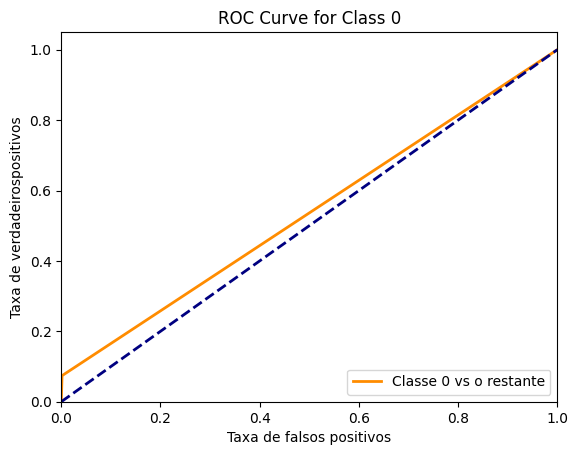

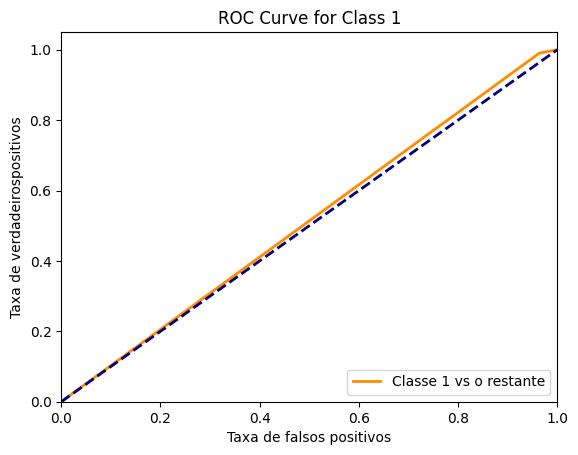

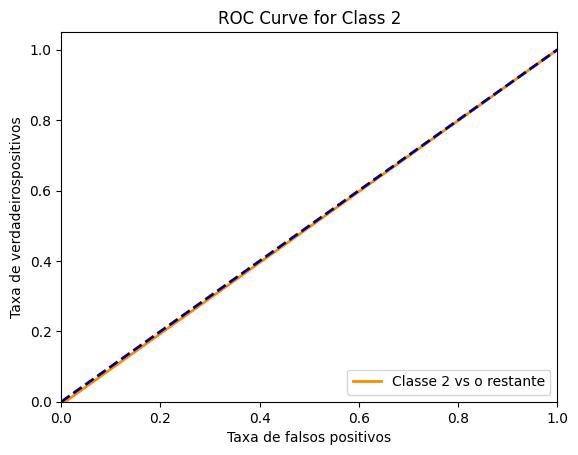

In [63]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plotCurveROC(class_id):
  # Calcule a curva ROC
  fpr, tpr, _ = roc_curve(y_test_class_bin[:, class_id], y_test_class_predict_bin[:, class_id])

  # Plote a curva ROC
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Classe {class_id} vs o restante")
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de verdadeirospositivos')
  plt.title(f'ROC Curve for Class {class_id}')
  plt.legend(loc='lower right')
  plt.show()

plotCurveROC(0)
plotCurveROC(1)
plotCurveROC(2)

In [64]:
# Calcular e imprimir as métricas de regressão
# mse = mean_squared_error(y_val, y_val_predict_results)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_val, y_val_predict_results)
# r2 = r2_score(y_val, y_val_predict_results)
# mape = np.mean(np.abs((y_val - y_val_predict_results) / y_val)) * 100

In [65]:
# y_val_predict.shape
# (303, 30, 1)
# 303: This is the number of data points or samples in your validation dataset. Each data point represents one day.
# 30: These are the time steps or sequence length used for making predictions. In your LSTM model, you are considering a sequence of 30 time steps to predict the next value.
# 1: This is the number of features being predicted. In your case, you are predicting the closing price of Bitcoin, which is a single numerical value.

In [66]:
# # Código para mais de uma camada de LSTM
# def build_multilayer_lstm_model(hp):
#   model = keras.Sequential()
#   for _ in range(hp.Int('num_lstm_layers', min_value=1, max_value=4)):
#       model.add(LSTM(
#           units=hp.Int('num_lstm_units', min_value=16, max_value=128, step=16),
#           return_sequences=True,
#           input_shape = (x_train.shape[1], x_train.shape[2]),
#           activation='relu'
#           ))
#       model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4)))
#   model.add(Dense(1))

#   optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log'))
#   model.compile(loss='mean_squared_error', optimizer=optimizer)

#   return model